In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams['savefig.facecolor']='white'

# Przygotowanie danych

In [27]:
cocoa = pd.read_csv('Cocoa.csv')
milk = pd.read_csv('Milk.csv')
sugar = pd.read_csv('Sugar.csv')

In [28]:
cocoa['Date'] = pd.to_datetime(cocoa['Date'])
milk['Date'] = pd.to_datetime(milk['Date'])
sugar['Date'] = pd.to_datetime(sugar['Date'])

In [29]:
cocoa['Close/Last'] = cocoa['Close/Last'].astype(float)
milk['Close/Last'] = milk['Close/Last'].astype(float)
sugar['Close/Last'] = sugar['Close/Last'].astype(float)

In [30]:
# Losowo wybrana wartość, żeby było tyle samo obserwacji XD
cocoa.drop(labels=[373],axis=0,inplace=True)
sugar.drop(labels=[373],axis=0,inplace=True)

In [31]:
cocoa.reset_index(inplace=True)
sugar.reset_index(inplace=True)

Zamiana danych na stopy procentowe.

In [32]:
T = 1/252
cocoa_close = np.array([round((cocoa['Close/Last'][i] - cocoa['Close/Last'][i+1])/(cocoa['Close/Last'][i+1] * T),3) for i in range(len(cocoa)-1)])
milk_close = np.array([round((milk['Close/Last'][i] - milk['Close/Last'][i+1])/(milk['Close/Last'][i+1] * T), 3) for i in range(len(milk)-1)])
sugar_close = np.array([round((sugar['Close/Last'][i] - sugar['Close/Last'][i+1])/(sugar['Close/Last'][i+1] * T), 3) for i in range(len(sugar)-1)])

In [33]:
cocoa_close /= -100
milk_close /= -100
sugar_close /= -100

# 1. Estymacja średnich, odchyleń standardowych i korelacji

In [34]:
mu_c = np.mean(cocoa_close)
sigma_c = np.std(cocoa_close)
print(mu_c, sigma_c)

mu_m = np.mean(milk_close)
sigma_m = np.std(milk_close)
print(mu_m, sigma_m)

mu_s = np.mean(sugar_close)
sigma_s = np.std(sugar_close)
print(mu_s, sigma_s)

-0.001117537728355838 0.046824757568405186
-0.0017505321683876094 0.06295608405526686
-0.00079417791898332 0.047974620097403456


In [35]:
n = len(cocoa_close)
C = cocoa_close.reshape(1,n)
M = milk_close.reshape(1,n)
S = sugar_close.reshape(1,n)
R = np.concatenate([C,M,S],axis=0)

In [36]:
corr = np.corrcoef(R)

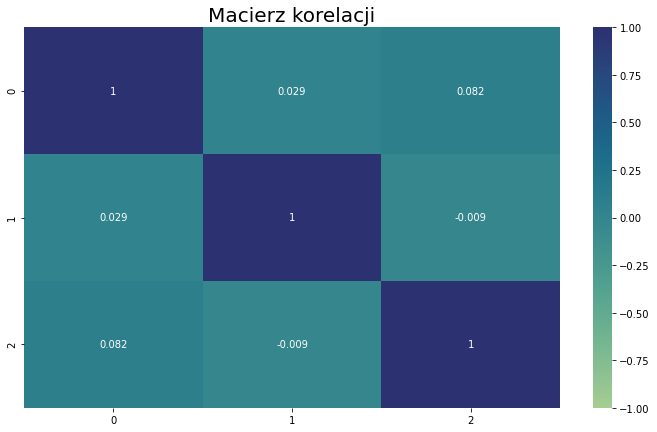

In [37]:
sns.heatmap(corr, annot=True, cmap="crest", vmin=-1, vmax=1)
plt.title("Macierz korelacji", fontsize=20)
plt.show()

## a) stopa zwrotu i ryzyko portfela z rzeczywistymi wagami 

In [38]:
Rp = 0.5 * cocoa_close + 0.2 * milk_close + 0.3 * sugar_close

In [39]:
print("Stopa zwrotu porfela: {}, ryzyko portfela: {}.".format(np.mean(Rp),np.std(Rp)))

Stopa zwrotu porfela: -0.0011471286735504369, ryzyko portfela: 0.031343476067965996.


## b) możliwe portfele dla różnych wag

In [40]:
param_list = np.arange(0,1.1,0.05)

In [41]:
combinations = []
for j in range(len(param_list)-1):
    for i in range(len(param_list)-1):
        vec = np.array([param_list[j], param_list[i], round(1-param_list[i]-param_list[j],2)])
        if (vec >= 0).sum() == vec.size and (vec <= 1).sum() == vec.size:
            combinations.append(vec)


In [51]:
expected_values = []
standard_deviations = []

for comb in combinations:
    R = comb[0] * cocoa_close + comb[1] * milk_close + comb[2] * sugar_close
    expected_values.append(np.mean(R))
    standard_deviations.append(np.sqrt(np.dot(comb.T, np.dot(np.cov(R), comb))))

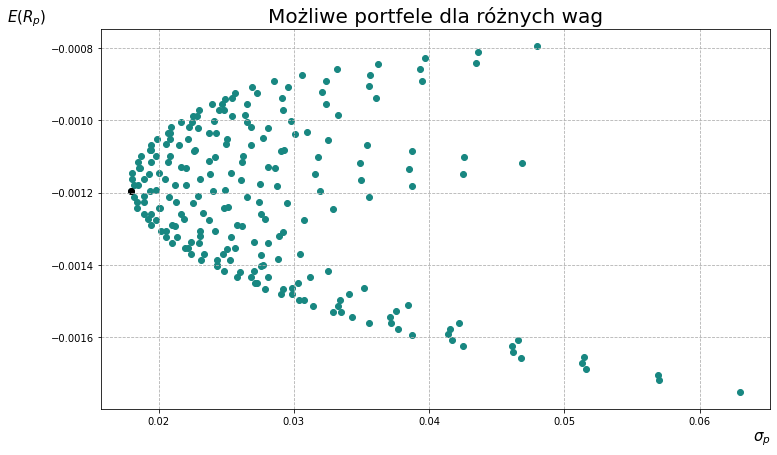

In [54]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.scatter(standard_deviations[132], expected_values[132], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

## c) portfel o minimalnym ryzyku

In [53]:
standard_deviations.index(min(standard_deviations))

132

In [56]:
expected_values[132], standard_deviations[132], combinations[132]

(-0.001194260127084988, 0.017979070481907618, array([0.35, 0.3 , 0.35]))

## d) portfel o minimalnym ryzyku przy ustalonej stopie zwrotu

In [81]:
# ustalona stopa zwrotu
r = -0.0012

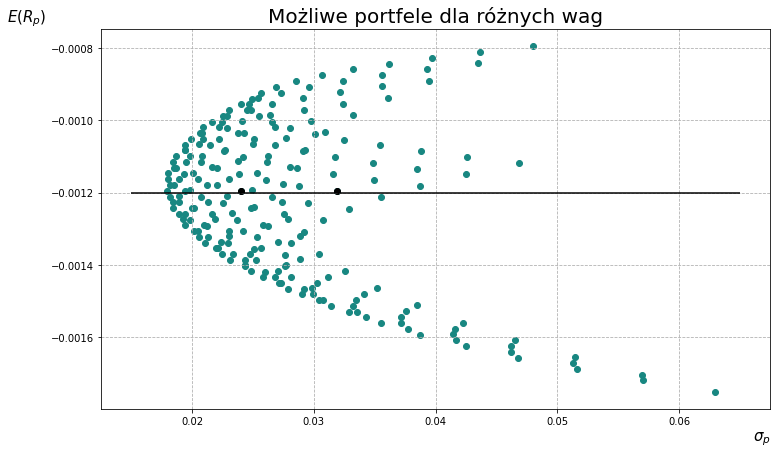

In [98]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.hlines(r, xmin=0.015, xmax=0.065, color='k')
plt.scatter([standard_deviations[i] for i in ind], [expected_values[i] for i in ind], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()

In [96]:
exp = np.array(expected_values).round(5)
ind = np.where(exp == r)[0].tolist()

In [97]:
ind

[199, 219]

In [90]:
b = min(expected_values, key=lambda x:abs(x-r))
expected_values.index(b)

219

In [99]:
expected_values[219], standard_deviations[219], combinations[219]

(-0.001196318903891978, 0.03193737817338809, array([0.8 , 0.15, 0.05]))

## e) portfel rynkowy

In [106]:
x = ((np.array(expected_values) - r)/np.array(standard_deviations)).tolist()

In [107]:
x.index(max(x))

126

In [109]:
expected_values[126], standard_deviations[126], combinations[126]

(-0.0009073538522637015, 0.02687766918711918, array([0.35, 0.  , 0.65]))

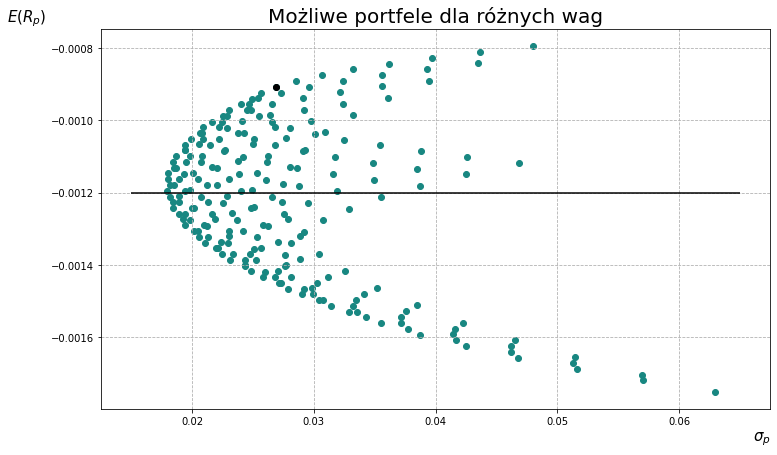

In [108]:
plt.scatter(standard_deviations, expected_values, color="#188781")
plt.hlines(r, xmin=0.015, xmax=0.065, color='k')
plt.scatter(standard_deviations[126], expected_values[126], color='k')
plt.title("Możliwe portfele dla różnych wag", fontsize=20)
plt.xlabel(r"$\sigma_p$", fontsize=15, loc="right")
plt.ylabel(r"$E(R_p)$", fontsize=15, rotation=0, loc="top")
plt.show()